In [1]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer

/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_table('../datasets/CheckThat_Lab/train_ml.tsv')
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_table('../datasets/CheckThat_Lab/test_ml.tsv')
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

In [3]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(5965, 3)
(663, 3)
(600, 2)


In [4]:
df.head()

sentence_id  \
0  50f8b1cc-b96e-4845-a9fd-44b62a7e7863   
1  e59ab113-c755-4b55-9753-0a4e2a607500   
2  cd26b610-d10a-4059-adbe-d5382c7af8e7   
3                   FAT_489-curl_03_007   
4  8c880770-a393-4cc8-ba17-89cbf57432d0   

                                            sentence label  
0    "Dat blijft bestaan, tot het wordt rechtgezet."   OBJ  
1  "Een samenleving waarin veel culturen samenlev...   OBJ  
2  Sul fronte opposto pare offuscata la posizione...  SUBJ  
3  كما يتم تنظيم المسيرات والمظاهرات أمام السفارا...   OBJ  
4  Denmark, Germany, and France have each seen 10...   OBJ

In [5]:
# Load the SBERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [34]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [39]:
# # save the embedding results
# pickle.dump(X_train, open("./train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("./dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("./test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("./train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("./dev_labels_originals.p", "wb"))

In [6]:
# load the embeddings
X_train = pickle.load(open("./train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("./dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("./test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("./train_labels_originals.p", "rb"))
y_dev = pickle.load(open("./dev_labels_originals.p", "rb"))

In [8]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [21]:
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernels, suffix, verbose):    
    for kernel in kernels:
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        baseline_results[f'SVM-{kernel} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        
        if verbose:
            print(f"SVM with kernel: {kernel}", end='\t')
            print(clf.score(X_dev, y_dev))


In [23]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose):
    for layer in layers:
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        baseline_results[f'MLP-{layer} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        
        if verbose:
            print(f"MLP with layers: {layer}", end='\t')
            print(clf.score(X_dev, y_dev))

In [24]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose):
    for n in n_estimators:
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        baseline_results[f'RandomForest-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        
        if verbose:
            print(f"Random Forest with n_estimators: {n}", end='\t')
            print(clf.score(X_dev, y_dev))

In [25]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose):
    for n in n_neighbors:
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        baseline_results[f'KNN-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)

        if verbose:
            print(f"KNN with n_neighbors: {n}", end='\t')
            print(clf.score(X_dev, y_dev))


In [26]:
def naive_bayes_classification(baseline_results, X_train, y_train, X_dev, y_dev, suffix, verbose):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    baseline_results[f'Naive-Bayes {suffix}'] = classification_report(y_dev, y_pred, output_dict=True, zero_division=0)
    
    if verbose:
        print(f'Naive Bayes\t{clf.score(X_dev, y_dev)}')

In [35]:
def run_classifiers(X_train, y_train, X_dev, y_dev, suffix='', verbose=False, results=None):
    if results is None:
        results = {}
    
    if verbose:
        print('Classifier\tAccuracy')
    
    svm_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    svm_classification(results, X_train, y_train, X_dev, y_dev, svm_kernels, suffix, verbose)

    layers = [
            (100,), 
            # (100, 100), 
            (200, 100), 
            (100, 50), 
            (200, 100, 50), 
            (100, 100, 100)
        ]
    mlp_classification(results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose)

    n_estimators = [10, 50, 100, 200, 500]
    random_forest_classification(results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose)

    n_neighbors = [10, 20, 50, 100, 200, 500]
    knn_classification(results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose)

    naive_bayes_classification(results, X_train, y_train, X_dev, y_dev, suffix, verbose)

    return results

In [91]:
# plot the best results for each classifier
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5)):
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(f"Baseline Results")
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            plt.text(v, i + .25, str(round(v, 2)), color='black')
        



In [78]:
baseline_results = run_classifiers(X_train, y_train, X_dev, y_dev)

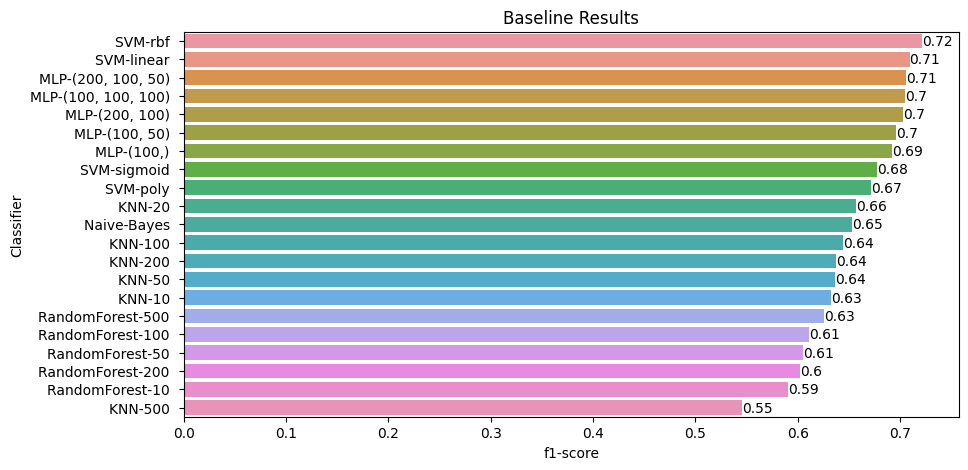

In [80]:
plot_results(baseline_results, 'f1-score')

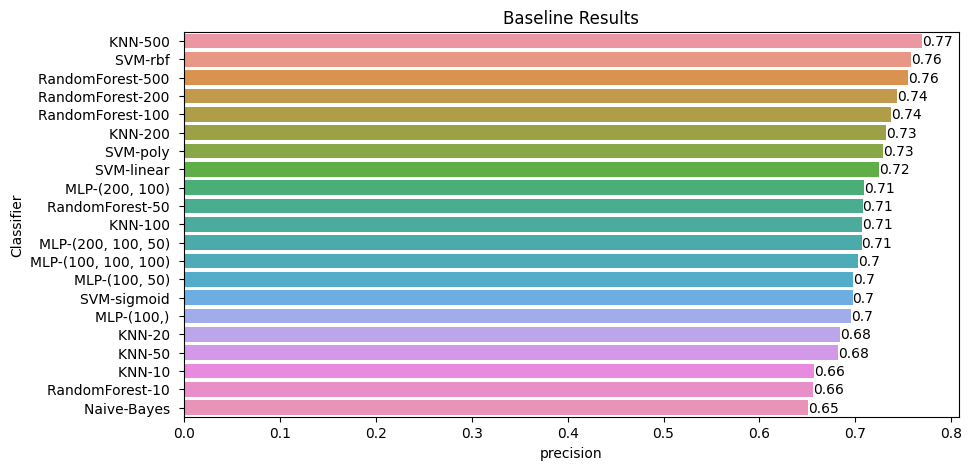

In [81]:
plot_results(baseline_results, 'precision')

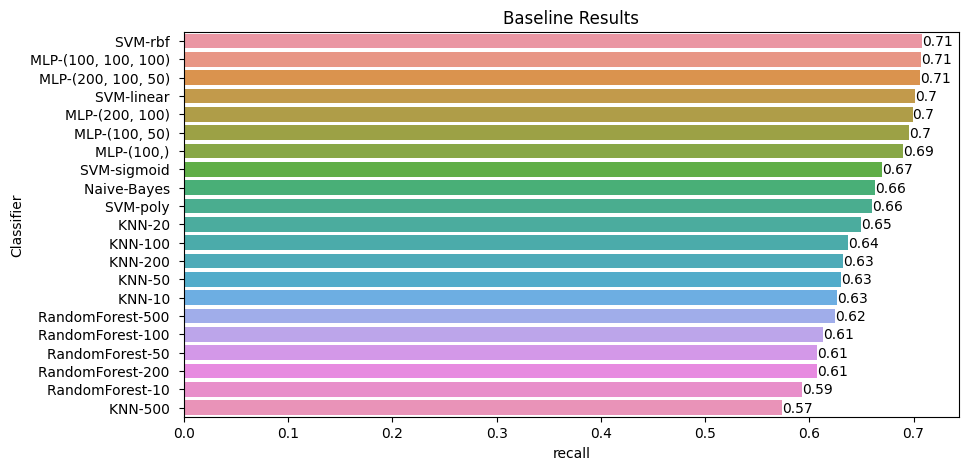

In [82]:
plot_results(baseline_results, 'recall')

## Proposed method

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

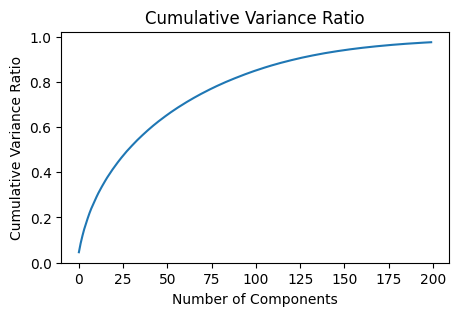

In [83]:
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_dev_pca = pca.transform(X_dev)

# plot the cumulative variance ratio
plt.figure(figsize=(5, 3))
plt.title("Cumulative Variance Ratio")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()



In [84]:
proposed_results = {}
pca_components = [10, 20, 50, 100, 200]
for n in pca_components:
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_dev_pca = pca.transform(X_dev)
    print(f"PCA with {n} components")
    run_classifiers(X_train_pca, y_train, X_dev_pca, y_dev, results=proposed_results, suffix=f'PCA-{n}')


PCA with 10 components
PCA with 20 components
PCA with 50 components
PCA with 100 components
PCA with 200 components


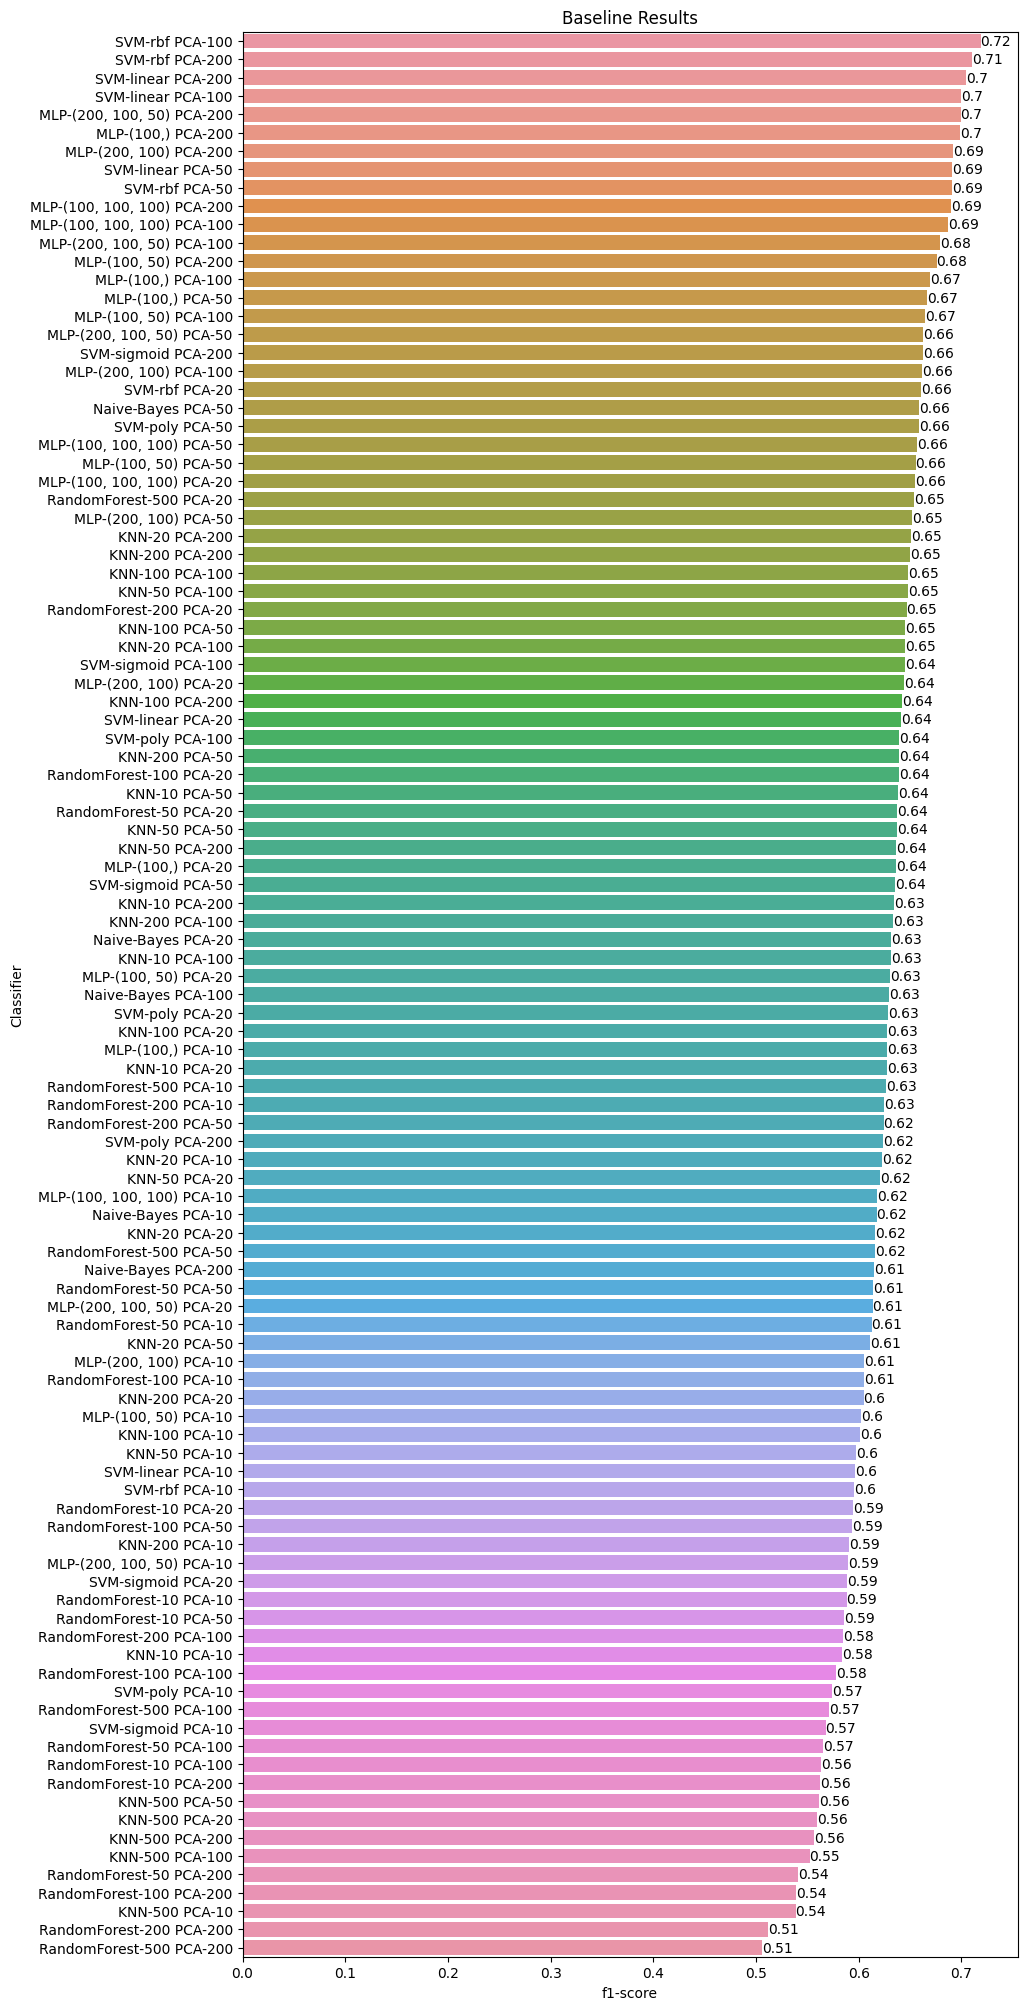

In [85]:
plot_results(proposed_results, 'f1-score', figsize=(10, 25))

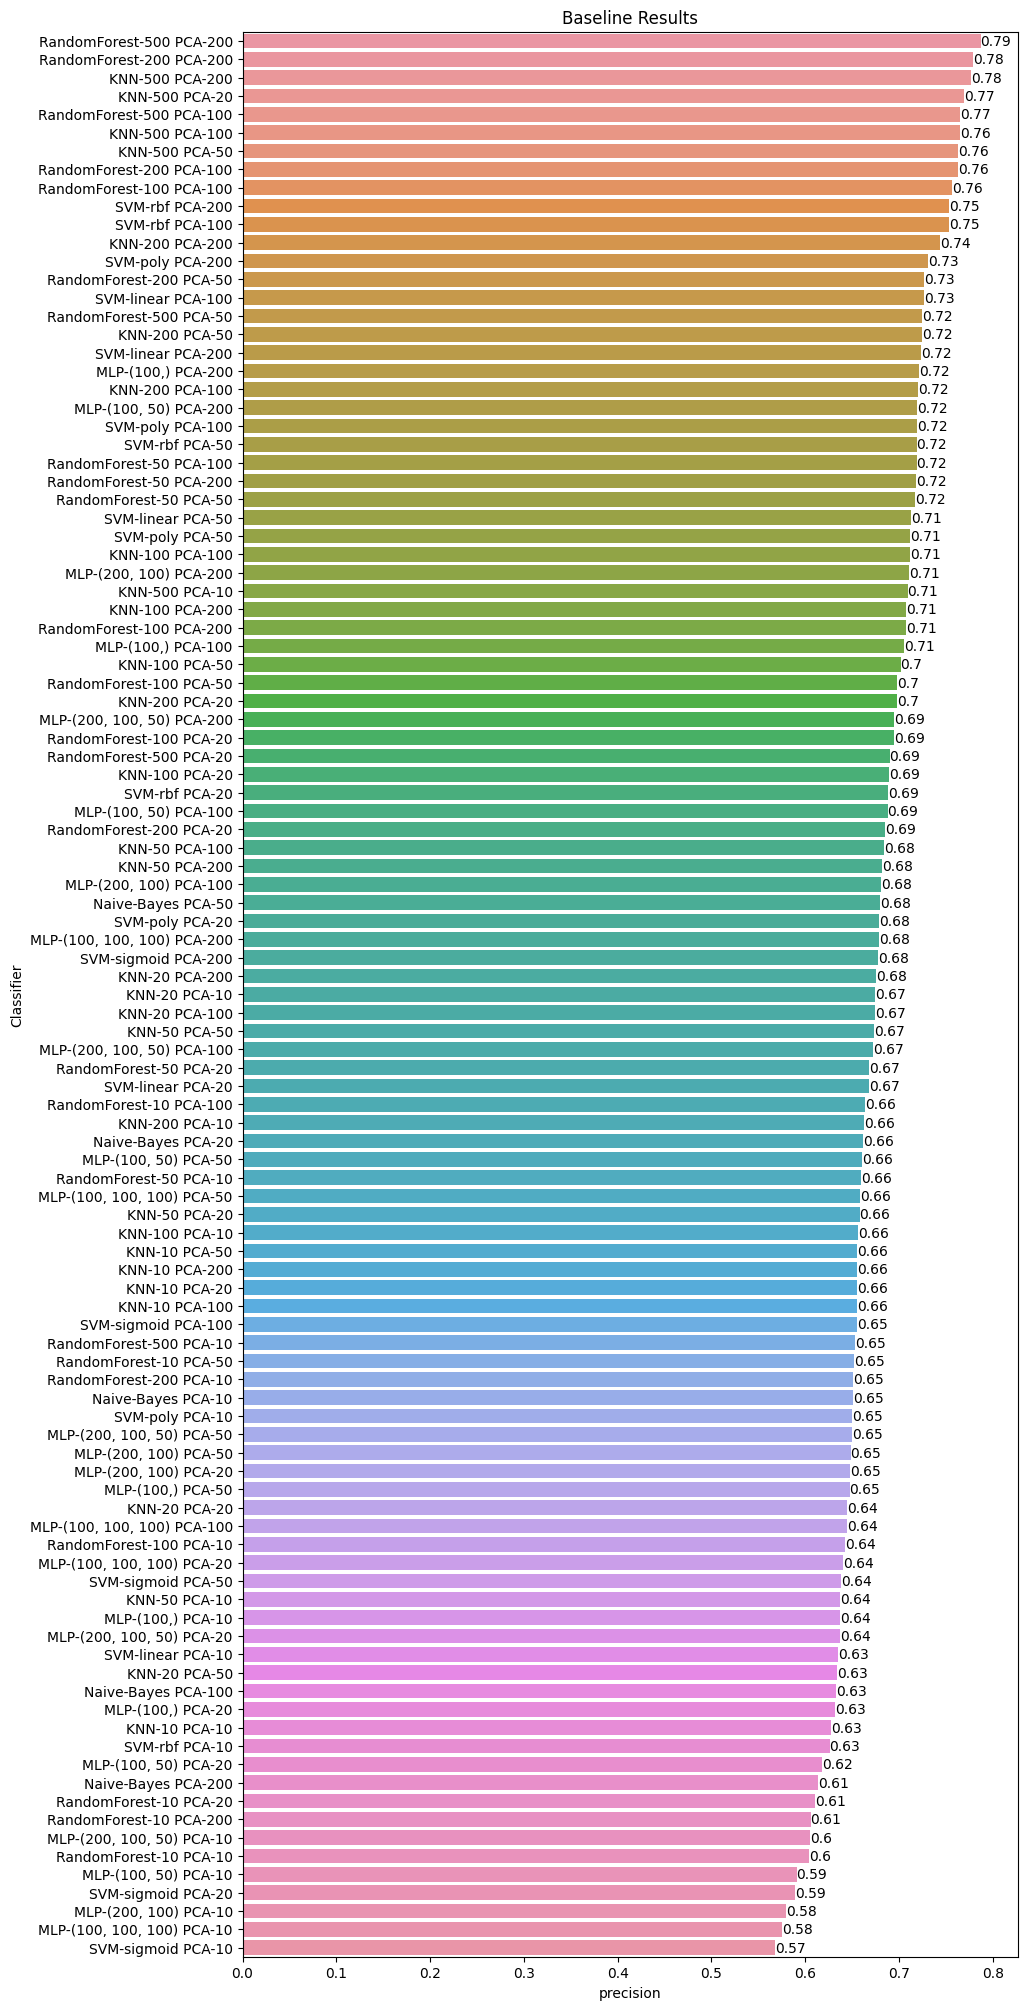

In [43]:
plot_results(proposed_results, 'precision', figsize=(10, 25))

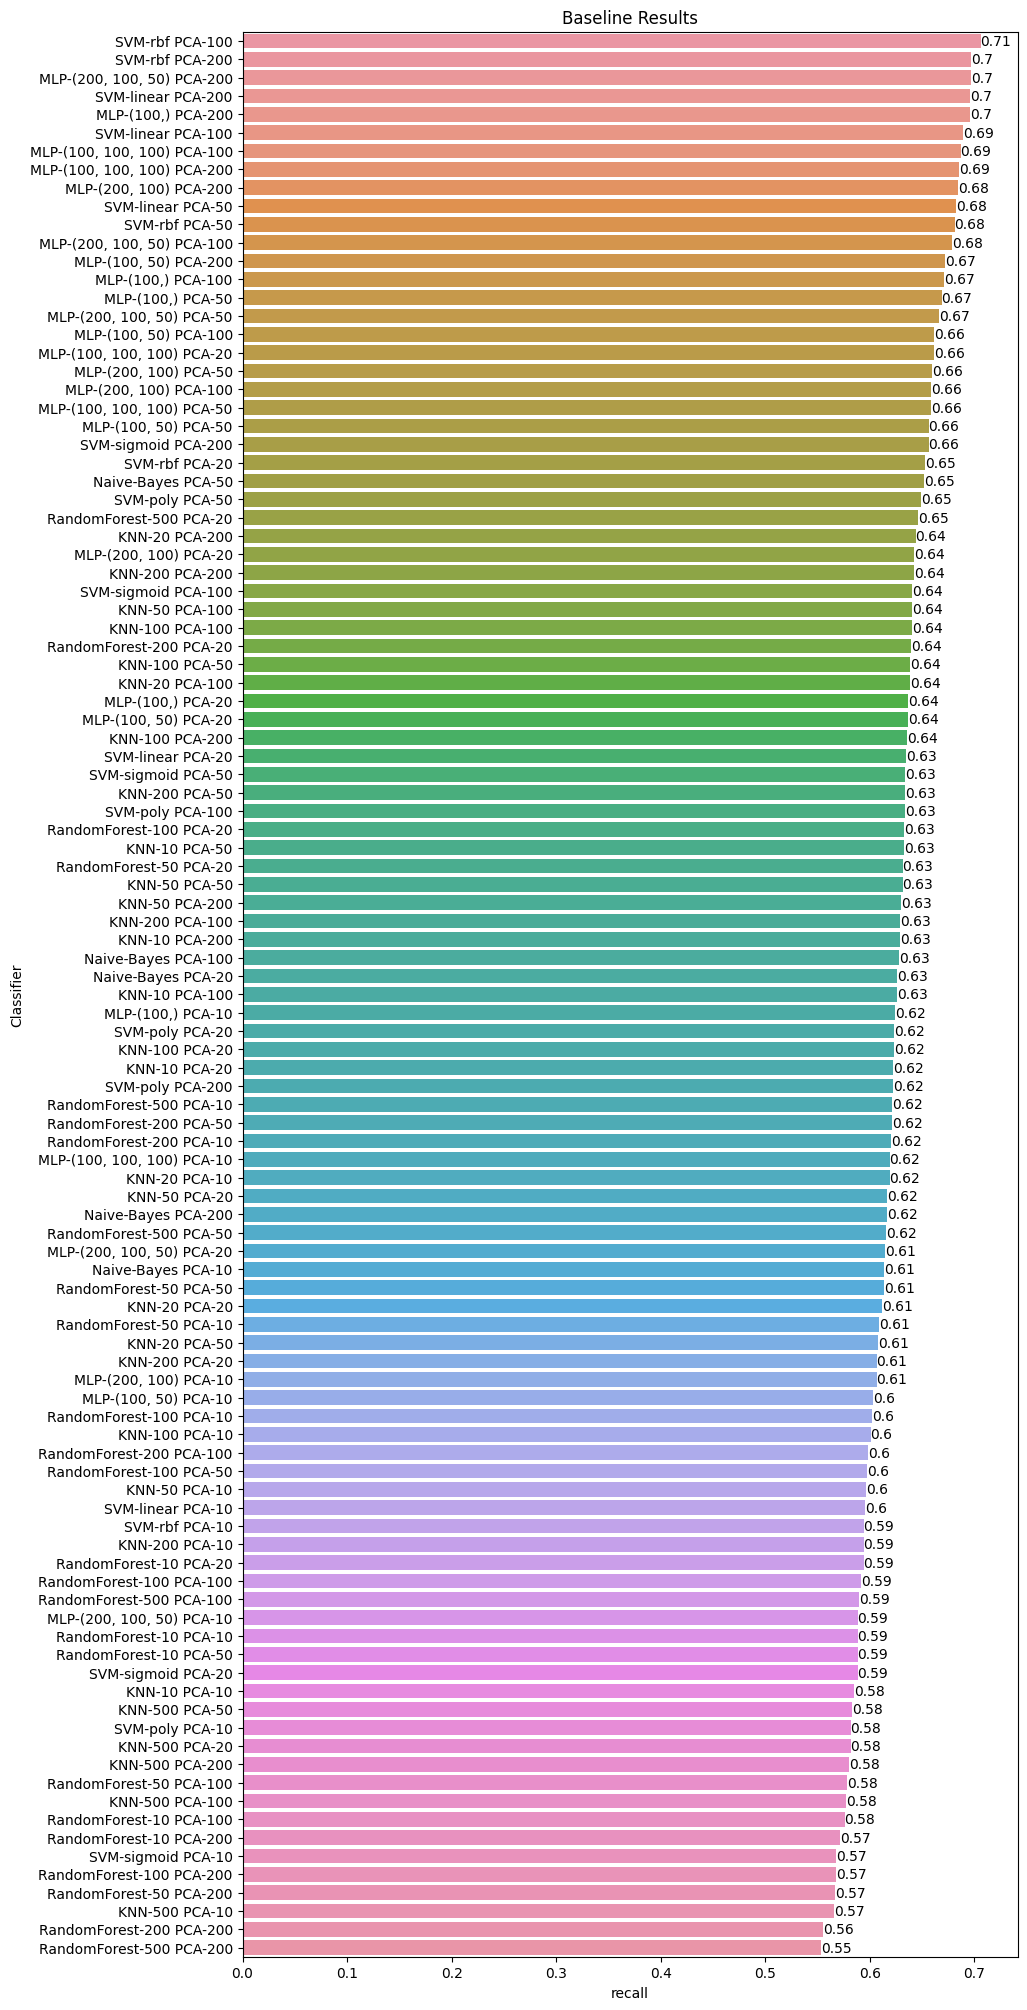

In [87]:
plot_results(proposed_results, 'recall', figsize=(10, 25))

In [88]:
# t-SNE
tsne_components = [10, 20, 50, 100, 200]
for n in tsne_components:
    tsne = TSNE(n_components=n, random_state=2000, method='exact')
    X_train_tsne = tsne.fit_transform(X_train[:500])
    X_dev_tsne = tsne.fit_transform(X_dev)
    print(f"t-SNE with {n} components")
    run_classifiers(X_train_tsne, y_train[:500], X_dev_tsne, y_dev, results=proposed_results, suffix=f't-SNE-{n}')


t-SNE with 10 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

t-SNE with 20 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

t-SNE with 50 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

t-SNE with 100 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

t-SNE with 200 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

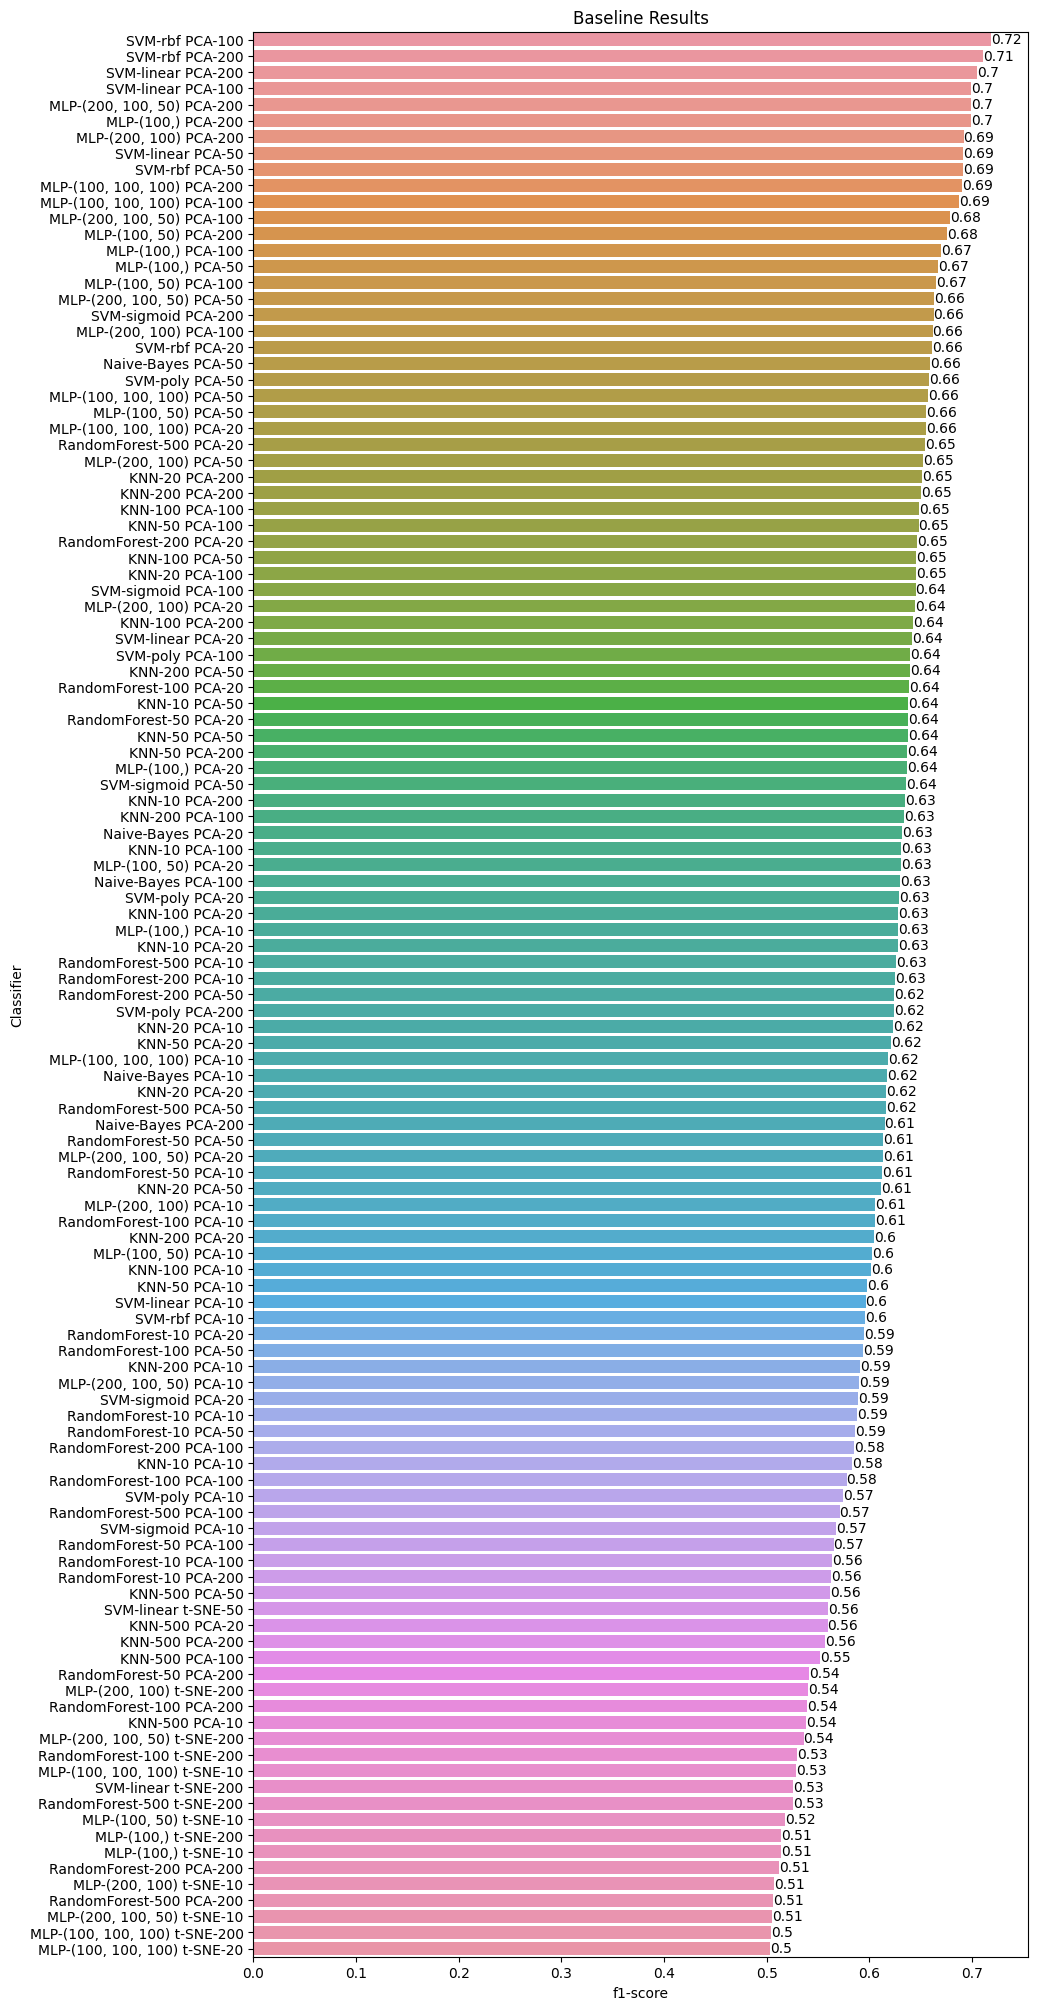

In [92]:
plot_results(proposed_results, 'f1-score', figsize=(10, 25), threshold=0.5)

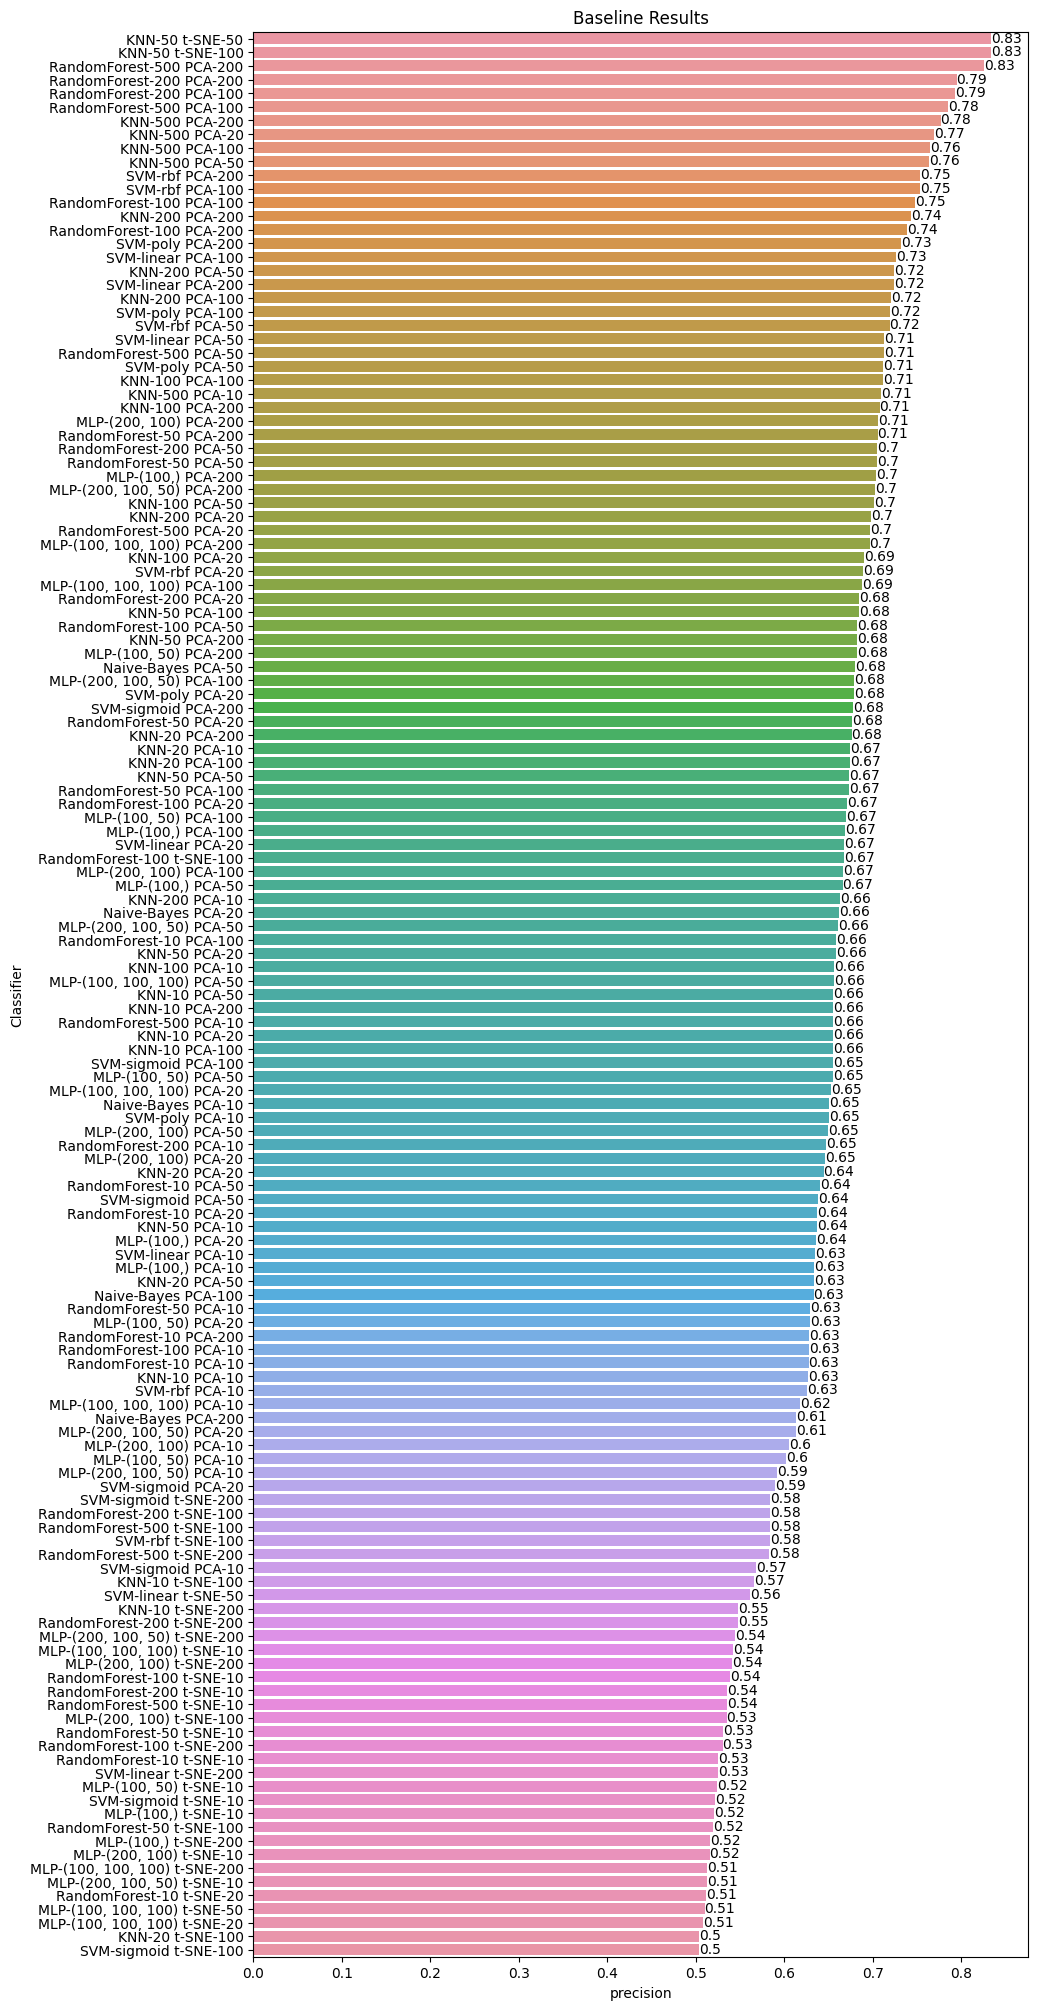

In [93]:
plot_results(proposed_results, 'precision', figsize=(10, 25), threshold=0.5)

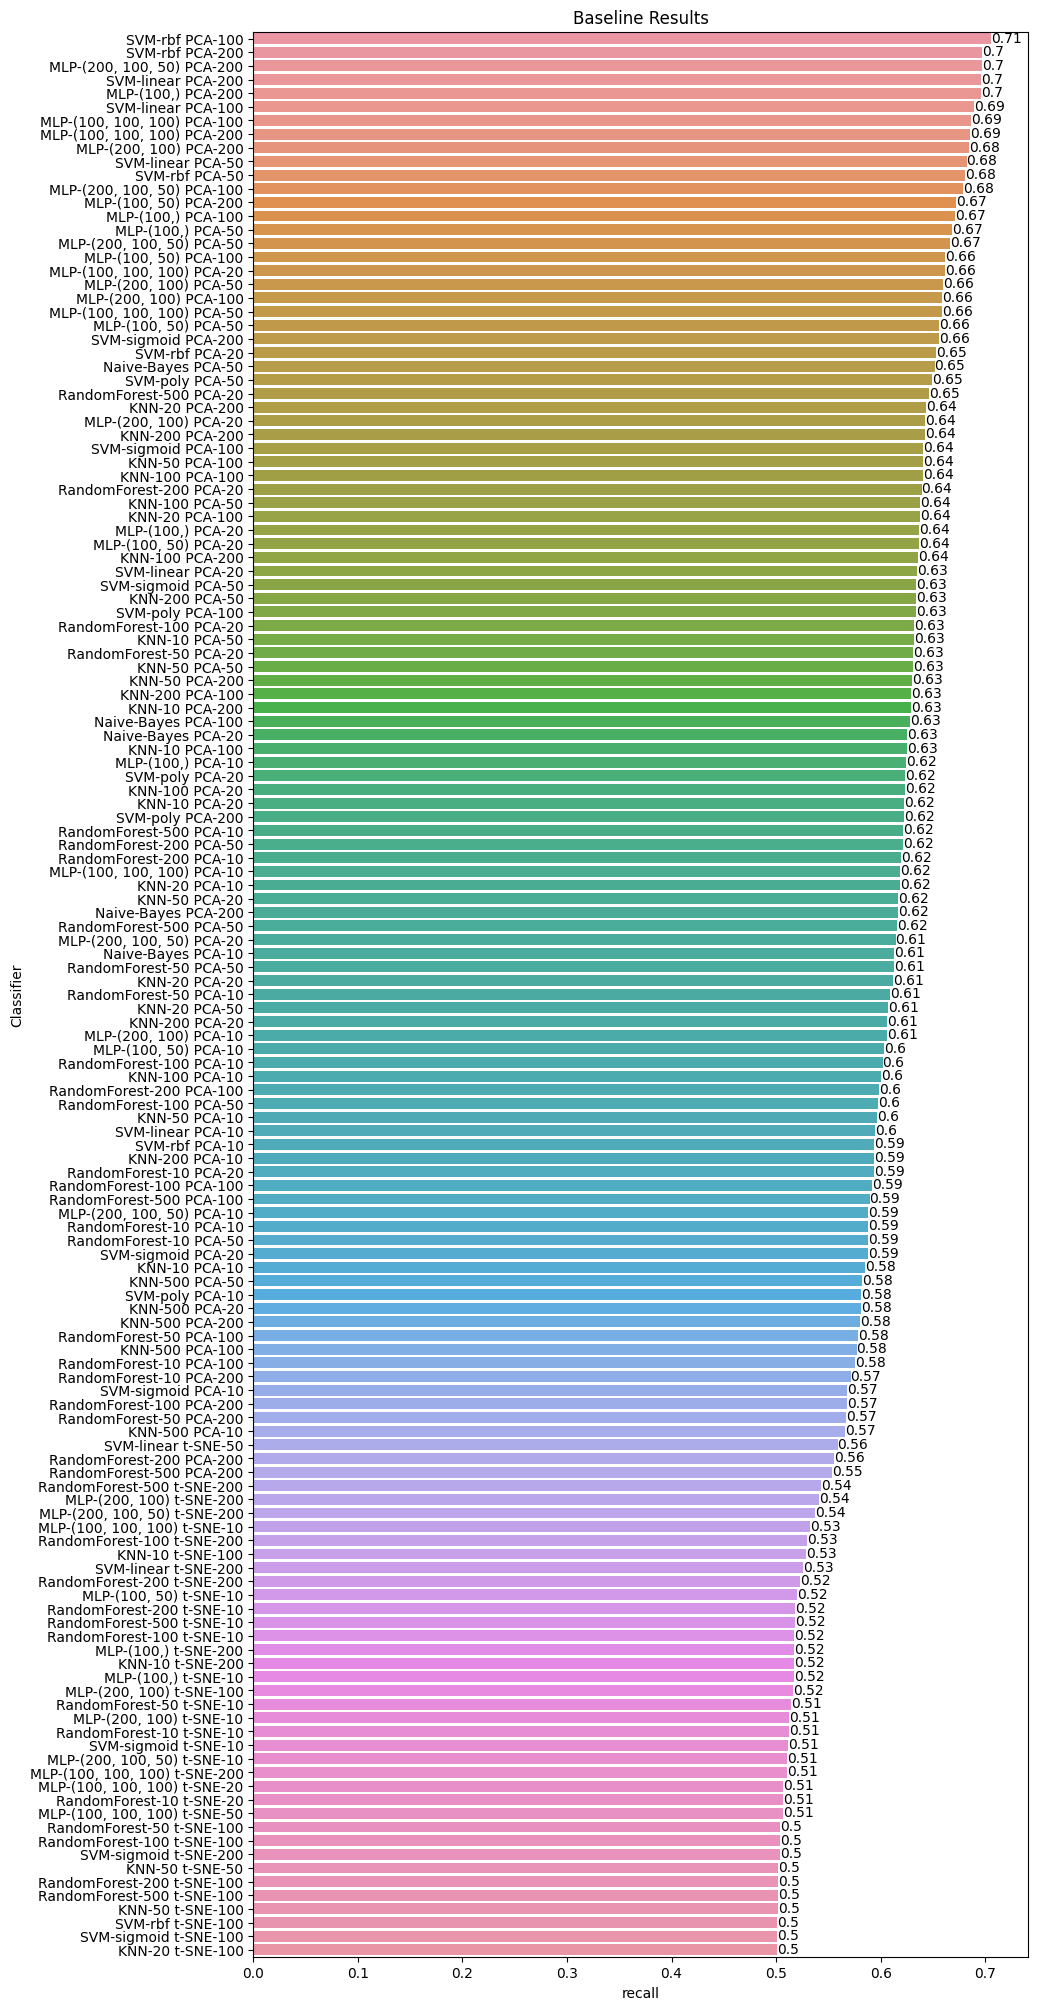

In [94]:
plot_results(proposed_results, 'recall', figsize=(10, 25), threshold=0.5)

In [95]:
# use LDA to reduce the dimensionality of the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_dev_lda = lda.transform(X_dev)

run_classifiers(X_train_lda, y_train, X_dev_lda, y_dev, suffix='LDA', results=proposed_results)

{'SVM-linear PCA-10': {'OBJ': {'precision': 0.7191011235955056,
   'recall': 0.8687782805429864,
   'f1-score': 0.7868852459016393,
   'support': 442},
  'SUBJ': {'precision': 0.5503875968992248,
   'recall': 0.3212669683257919,
   'f1-score': 0.4057142857142857,
   'support': 221},
  'accuracy': 0.6862745098039216,
  'macro avg': {'precision': 0.6347443602473652,
   'recall': 0.5950226244343891,
   'f1-score': 0.5962997658079625,
   'support': 663},
  'weighted avg': {'precision': 0.662863281363412,
   'recall': 0.6862745098039216,
   'f1-score': 0.6598282591725215,
   'support': 663}},
 'SVM-poly PCA-10': {'OBJ': {'precision': 0.7087719298245614,
   'recall': 0.9140271493212669,
   'f1-score': 0.7984189723320159,
   'support': 442},
  'SUBJ': {'precision': 0.5913978494623656,
   'recall': 0.248868778280543,
   'f1-score': 0.35031847133757965,
   'support': 221},
  'accuracy': 0.6923076923076923,
  'macro avg': {'precision': 0.6500848896434634,
   'recall': 0.5814479638009049,
   'f1-

In [103]:
all_results = {**baseline_results, **proposed_results}

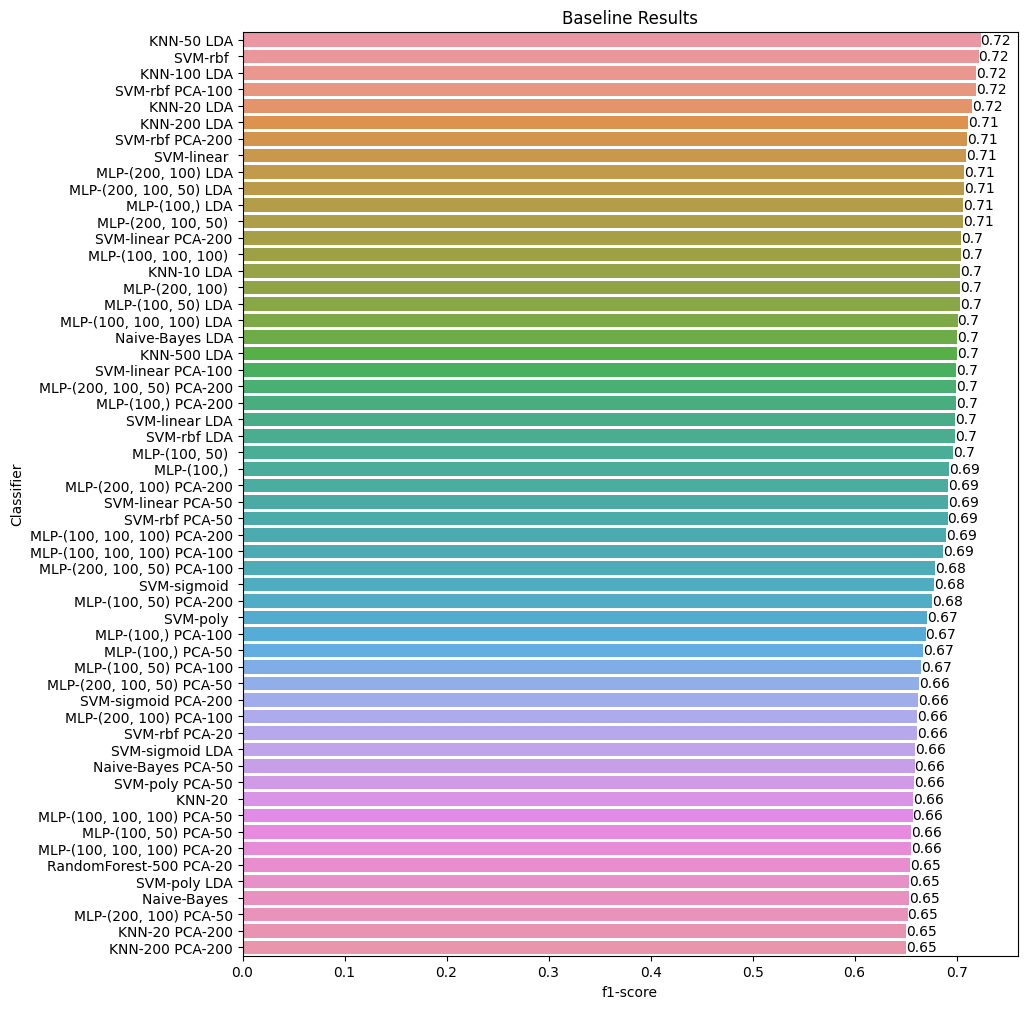

In [107]:
plot_results(all_results, 'f1-score', figsize=(10, 12), threshold=0.65)

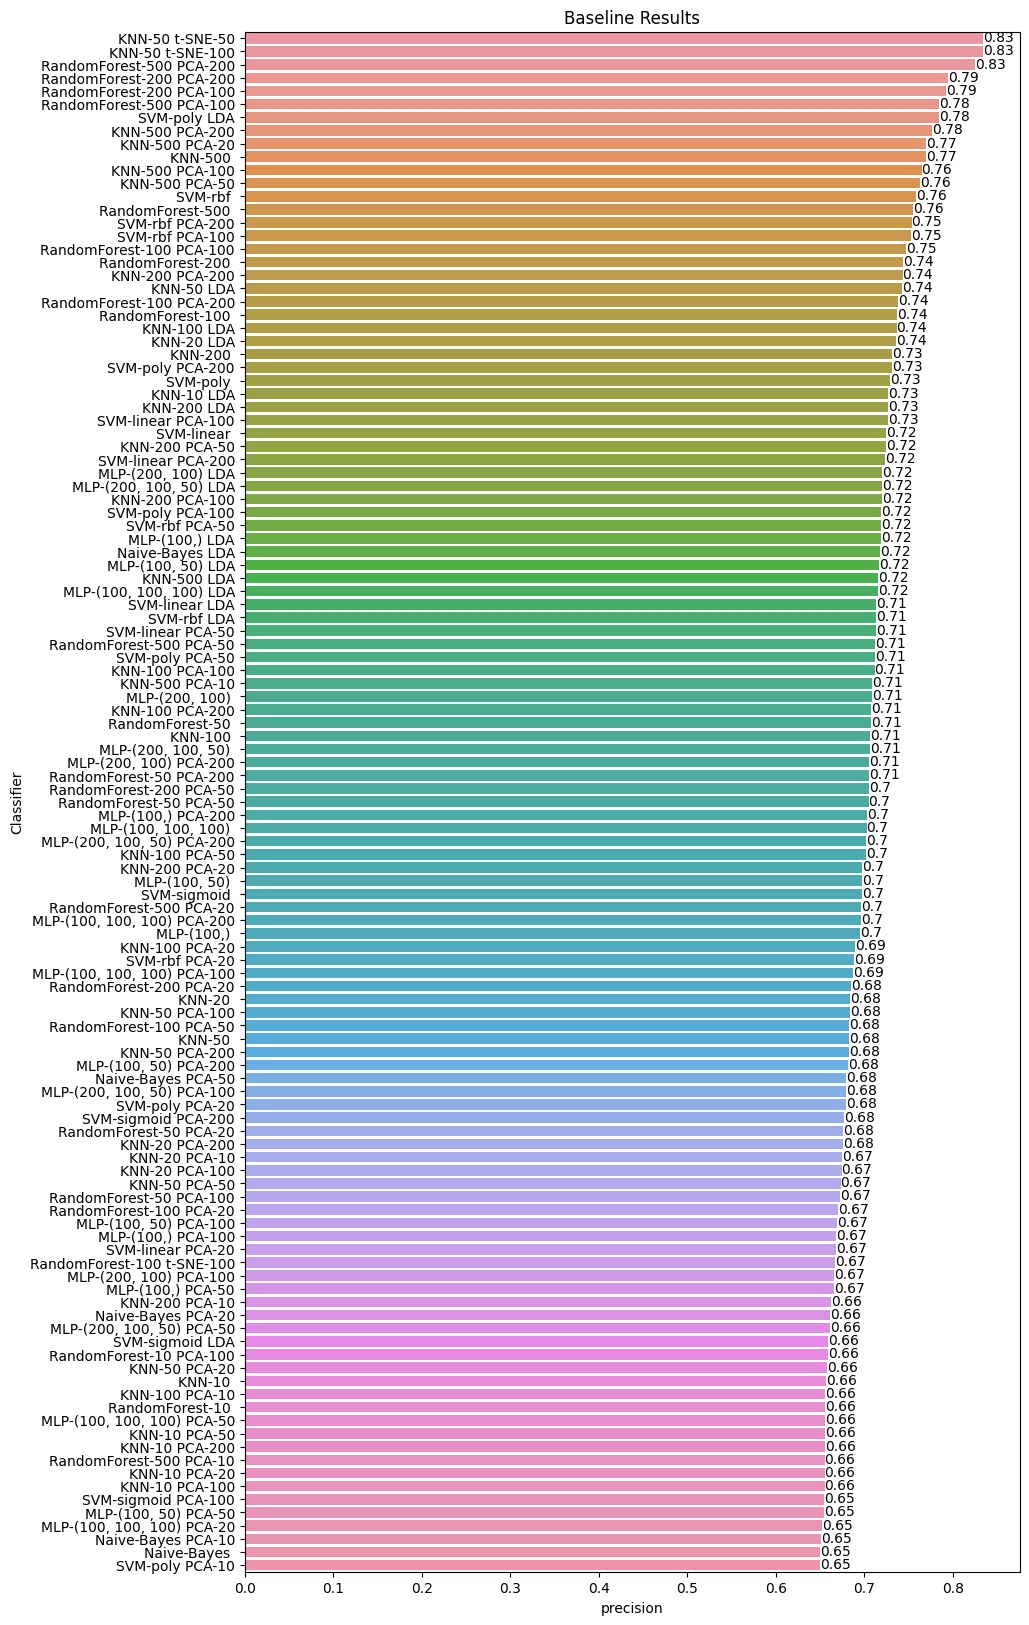

In [110]:
plot_results(all_results, 'precision', figsize=(10, 20), threshold=0.65)

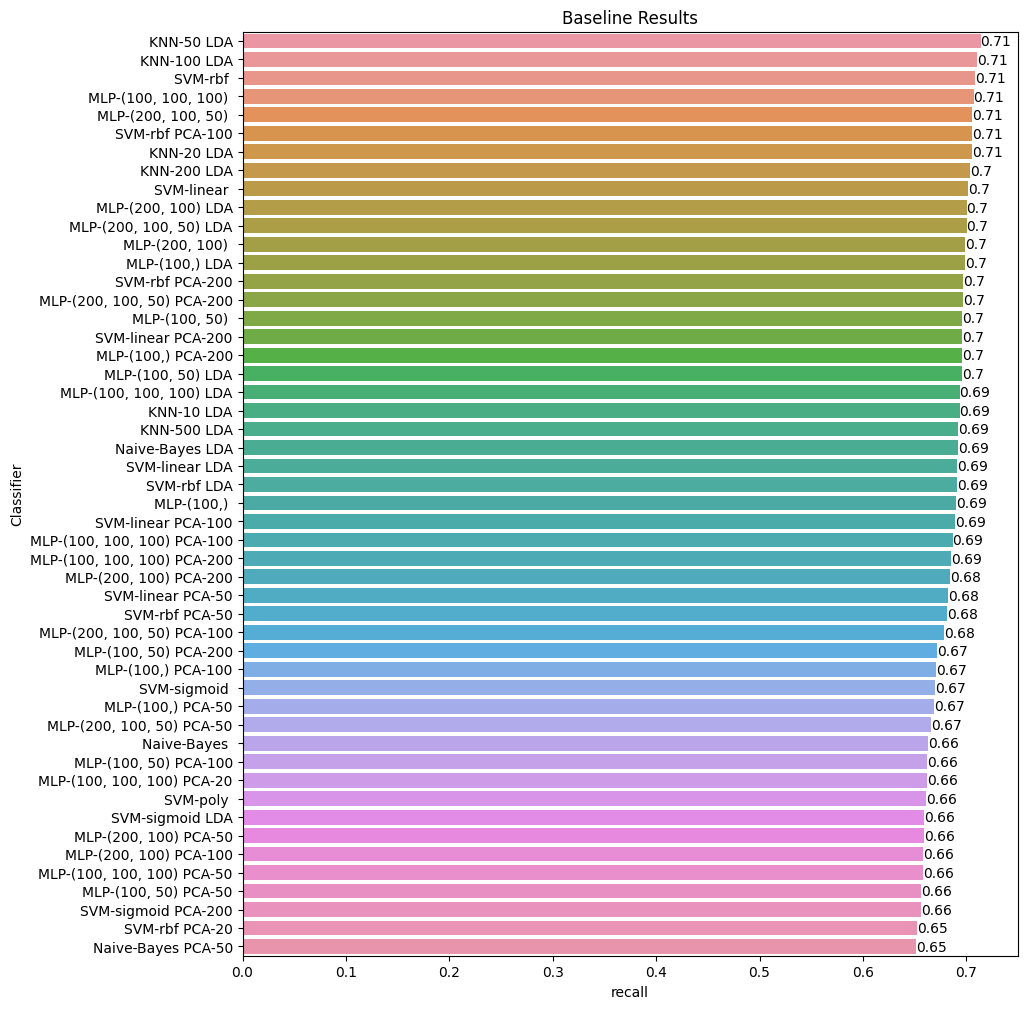

In [112]:
plot_results(all_results, 'recall', figsize=(10, 12), threshold=0.65)

In [114]:
# save all_results, proposed_results, baseline_results
import pickle

with open('all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

with open('proposed_results.pkl', 'wb') as f:
    pickle.dump(proposed_results, f)

with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)
